# Model 2 - TSP Genetic Algorithm

In [1]:
import sys, math, random, heapq
import matplotlib.pyplot as plt
from itertools import chain

class Graph:

    def __init__(self, vertices):
        self.vertices = vertices
        self.n = len(vertices)

    def x(self, v):
        return self.vertices[v][0]

    def y(self, v):
        return self.vertices[v][1]

    # Lookup table for distances
    _d_lookup = {}

###########################################################################
##### PART 1: Converts grid co-ordinates of the nodes into a distance matrix

    def d(self, u, v):
        # Check if the distance was computed before
        if (u, v) in self._d_lookup:
            return self._d_lookup[(u, v)]
        # Otherwise compute euclidean distance
        _distance = math.sqrt((u[0] - v[0])**2 + (u[1] - v[1])**2)
        # Add to dictionary
        self._d_lookup[(u, v)], self._d_lookup[(v, u)] = _distance, _distance
#         if self._d_lookup[(u, v)] != self._d_lookup[(v, u)]:
#             self._d_lookup[(u, v)] = _distance
        
        return _distance

###########################################################################
##### PART 2: Plots the final optimal route

    def plot(self, tour=None):
        """Plots the cities and superimposes given tour"""
        if tour is None:
            tour = Tour(self, [])

        _vertices = [self.vertices[0]]

        for i in tour.vertices:
            _vertices.append(self.vertices[i])

        _vertices.append(self.vertices[0])

#         plt.title("Cost = " + str(tour.cost()))
        plt.plot(*zip(*_vertices), '-r')
        plt.scatter(*zip(*self.vertices), c="b", s=10, marker="s")
        plt.show()
        print("Vertices for locations are:\n", _vertices)                     #M - priting vertices
        
###########################################################################
##### PART 2a: Plots the optimal route without returning to first node

    def plot2(self, tour=None):
        """Plots the cities and superimposes given tour"""
        if tour is None:
            tour = Tour(self, [])

        _vertices = [self.vertices[0]]

        for i in tour.vertices:
            _vertices.append(self.vertices[i])

        _vertices.append(self.vertices[0])

#         plt.title("Cost = " + str(tour.cost()))
        plt.plot(*zip(*_vertices[0:-1]), '-r')
        plt.scatter(*zip(*self.vertices), c="b", s=10, marker="s")
        plt.show()
        print("Vertices for locations are:\n", _vertices)                     #M - priting vertices

###########################################################################
##### PART 3: Calculates the distance of a given (full) path
class Tour:

    def __init__(self, g, vertices = None):
        """Generate random tour in given graph g"""
        self.g = g
        if vertices is None:
            self.vertices = list(range(1, g.n))
            random.shuffle(self.vertices)
        else:
            self.vertices = vertices
        self.__cost = None

    def cost(self):
        """Return total edge-cost of tour"""
        if self.__cost is None:
            self.__cost = 0
            for i, j in zip([0] + self.vertices, self.vertices + [0]):
                self.__cost += self.g.d(self.g.vertices[i], self.g.vertices[j])
#                 print(self.__cost)
        return self.__cost

###########################################################################
##### PART 4: IMPORTANT Main GA parameters (Probability of creating each type of child)

class GeneticAlgorithm:

    def __init__(self, g, population_size, k=5, elite_mating_rate=0.5,
                 mutation_rate=0.015, mutation_swap_rate=0.2):   #Probability of each type of child being created
        """Initialises algorithm parameters"""

        self.g = g
        
        self.population = []
        for _ in range(population_size):
            self.population.append(Tour(g))

        self.population_size = population_size
        self.k = k
        self.elite_mating_rate = elite_mating_rate
        self.mutation_rate = mutation_rate
        self.mutation_swap_rate = mutation_swap_rate
        
###########################################################################
##### PART 5 = Crossover - as described in Teaching Material (Week 11 = AI)

    def crossover(self, mum, dad):
        """Implements ordered crossover"""
        size = len(mum.vertices)

        # Choose random start/end position for crossover
        alice, bob = [-1] * size, [-1] * size
        start, end = sorted([random.randrange(size) for _ in range(2)])

        # Replicate mum's sequence for alice, dad's sequence for bob
        for i in range(start, end + 1):
            alice[i] = mum.vertices[i]
            bob[i] = dad.vertices[i]

        # Fill the remaining position with the other parents' entries
        current_dad_position, current_mum_position = 0, 0

        for i in chain(range(start), range(end + 1, size)):

            while dad.vertices[current_dad_position] in alice:
                current_dad_position += 1

            while mum.vertices[current_mum_position] in bob:
                current_mum_position += 1

            alice[i] = dad.vertices[current_dad_position]
            bob[i] = mum.vertices[current_mum_position]

        # Return twins
        return Tour(self.g, alice), Tour(self.g, bob)

###########################################################################
##### PART 6 = Mutation - swaps pairs, as in TSP_HillClimb.py and described in Week 10, but can swap multiple pairs.
    def mutate(self, tour):
        """Randomly swaps pairs of cities in a given tour according to mutation rate"""

        # Decide whether to mutate
        if random.random() < self.mutation_rate:

            # For each vertex
            for i in range(len(tour.vertices)):

                # Randomly decide whether to swap node i
                if random.random() < self.mutation_swap_rate:

                    # Randomly choose other node to swap j
                    j = random.randrange(len(tour.vertices))

                    # Swap i and j
                    tour.vertices[i], tour.vertices[j] = tour.vertices[j], tour.vertices[i]

###########################################################################
##### PART 7 = Selects the fittest parents = takes a random sample of solutions and picks "best" solutions from that sample
    def select_parent(self, k):
        """Implements k-tournament selection to choose parents"""
        tournament = random.sample(self.population, k)
        return max(tournament, key=lambda t: t.cost())

    
###########################################################################
##### PART 8 = Creates the new populatio for the next generation

    def evolve(self):
        """Executes one iteration of the genetic algorithm to obtain a new generation"""

        new_population = []

        for _ in range(self.population_size):

            # K-tournament for parents
            mum, dad = self.select_parent(self.k), self.select_parent(self.k)
            alice, bob = self.crossover(mum, dad)

            # Elitism = keep existing (best) solution, do not change
            if random.random() < self.elite_mating_rate:
                if alice.cost() < mum.cost() or alice.cost() < dad.cost():
                    new_population.append(alice)
                if bob.cost() < mum.cost() or bob.cost() < dad.cost():
                    new_population.append(bob)

            else:
                self.mutate(alice)
                self.mutate(bob)
                new_population += [alice, bob]

        # Add new population to old
        self.population += new_population

        # Elitism = keep existing (best) solution, do not change
        self.population = heapq.nsmallest(self.population_size, self.population, key=lambda t: t.cost())

###########################################################################
##### PART 9 = IMPORTANT ##### number of generations = (similar to number of steps in hill-climb)

    def run(self, iterations=200):  #Number of Generations: more = better, but takes longer
        for _ in range(iterations):
            self.evolve()

    def best(self):
        return max(self.population, key=lambda t: t.cost())


C:\Users\Mira\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Mira\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\Mira\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Warehouse 1

## Route 1 ------- W1 -> 6 -> W1  (Route to Lorry_1)

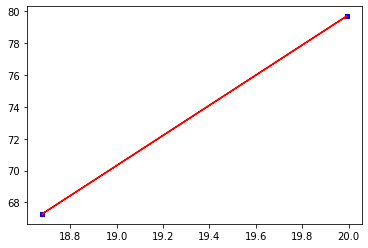

Vertices for locations are:
 [(19.9906676704456, 79.6926263050003), (18.6794883893845, 67.2743901634899), (19.9906676704456, 79.6926263050003)]
Best path: [1, 2] 
Total distance: 24.97452942286594

Price for this route 1 is:  49.94905884573188


In [2]:
###########################################################################
##### PART 10 =  IMPORTANT ## Input the data for the problem

g = Graph([    
(19.9906676704456,79.6926263050003),#W1
(18.6794883893845,67.2743901634899),#6       
])

###########################################################################
##### PART 11 = IMPORTANT ## Runs the main GA (including population size)

ga = GeneticAlgorithm(g, 100)    #Inputs (graph co-ordinates, POPULATION SIZE)  more = better, but takes longer
ga.run()

########## Output
best_tour = ga.best()
g.plot(best_tour)   #Plots the path on a graph

best_path = best_tour.vertices
size = len (g.vertices)
for i in range(size-1):
    best_path[i]=best_path[i]+1   #Must +1 to nodes to chnage numbering from (0,n-1) to (1,n)
best_path.insert(0,1)   #Adds start node to the list
Dist_route1 = best_tour._Tour__cost
print("Best path:", best_path, "\nTotal distance:",Dist_route1)   #Prints the best path and distance

######### Price 

# Lorry costs £2 per mile
P_Lorry = 2
Price_Rout1 = best_tour._Tour__cost * P_Lorry
print("\nPrice for this route 1 is: ", Price_Rout1)

#  Distance 6 -> W1

In [22]:
######### 
# 1 way distance from W1 to store 6

Rout_6_W1 = Dist_route1/2
print(Rout_6_W1)

12.48726471143297


## Route 2 ------- W1-> 20 -> 5 ->12 -> 4 -> 6

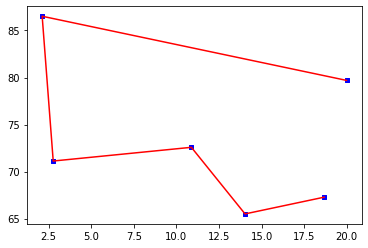

Vertices for locations are:
 [(19.9906676704456, 79.6926263050003), (2.11897096450746, 86.5148544660837), (2.76790974222021, 71.1176072605653), (10.8797000941924, 72.5752467820306), (14.031734193723, 65.4926922540545), (18.6794883893845, 67.2743901634899), (19.9906676704456, 79.6926263050003)]
Best path: [1, 6, 4, 5, 3, 2] 
Total distance: 55.5120375571654

Price for this route 2 is:  55.5120375571654


In [21]:
###########################################################################
##### PART 10 =  IMPORTANT ## Input the data for the problem

g = Graph([    
(19.9906676704456,79.6926263050003),#W1
(18.6794883893845,67.2743901634899),#6     
(14.031734193723,65.4926922540545),#4
(2.76790974222021,71.1176072605653),#5
(10.8797000941924,72.5752467820306),#12
(2.11897096450746,86.5148544660837),#20    
])

###########################################################################
##### PART 11 = IMPORTANT ## Runs the main GA (including population size)

ga = GeneticAlgorithm(g, 100)    #Inputs (graph co-ordinates, POPULATION SIZE)  more = better, but takes longer
ga.run()


########## Output
best_tour = ga.best()
g.plot2(best_tour)   #Plots the path on a graph

best_path = best_tour.vertices
size = len (g.vertices)
for i in range(size-1):
    best_path[i]=best_path[i]+1   #Must +1 to nodes to chnage numbering from (0,n-1) to (1,n)
best_path.insert(0,1)   #Adds start node to the list

#Negating distance from store 6 to W1 as Van is not going back to store here
Dist_route2 = best_tour._Tour__cost - Rout_6_W1
print("Best path:", best_path, "\nTotal distance:", Dist_route2)   #Prints the best path and distance


######### Price
# Van costs £1 pound per mile
P_Van1 = 1
Price_Rout2 = Dist_route2 * P_Van1
print("\nPrice for this route 2 is: ", Price_Rout2)

## Route 3 -------  6 -> 23 -> 9 -> 17 -> 2 -> 14

Best path: [1] 
Distance between 14 to 6: 41.189805305031115


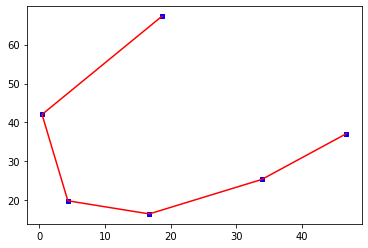

Vertices for locations are:
 [(18.6794883893845, 67.2743901634899), (0.435979595346347, 42.0535838452666), (4.36025048478595, 19.8891244405433), (16.7414536355628, 16.5160503087941), (33.86168368335, 25.3593730700641), (46.7438178442938, 37.1248715385984), (18.6794883893845, 67.2743901634899)]
Best path: [1, 3, 5, 4, 2, 6] 
Total distance: 103.1847288582882

Price for this route 3 is:  103.1847288582882


In [20]:
#########################################################################################################
##### Calculate the distance between 14 to 6 and negate from the path as van will not go back to store 6

g = Graph([    
(18.6794883893845,67.2743901634899),#6       
(46.7438178442938,37.1248715385984),#14  
])

###########################################################################
##### PART 11 = IMPORTANT ## Runs the main GA (including population size)

ga = GeneticAlgorithm(g, 100)    #Inputs (graph co-ordinates, POPULATION SIZE)  more = better, but takes longer
ga.run()


# ########## Output
best_tour = ga.best()
best_path = best_tour.vertices

dist_14_6 = best_tour._Tour__cost/2
print("Best path:", best_path, "\nDistance between 14 to 6:",dist_14_6)   #Prints the best path and distance




###########################################################################
##### PART 10 =  Calculate the distance between these stores

g = Graph([    
(18.6794883893845,67.2743901634899),#6       
(33.86168368335,25.3593730700641),#2
(0.435979595346347,42.0535838452666),#23
(16.7414536355628,16.5160503087941),#17
(4.36025048478595,19.8891244405433),#9
(46.7438178442938,37.1248715385984),#14      
])


###########################################################################
##### PART 11 = IMPORTANT ## Runs the main GA (including population size)

ga = GeneticAlgorithm(g, 100)    #Inputs (graph co-ordinates, POPULATION SIZE)  more = better, but takes longer
ga.run()


########## Output
best_tour = ga.best()
g.plot2(best_tour)   #Plots the path on a graph

best_path = best_tour.vertices
size = len (g.vertices)
for i in range(size-1):
    best_path[i]=best_path[i]+1   #Must +1 to nodes to chnage numbering from (0,n-1) to (1,n)
best_path.insert(0,1)   #Adds start node to the list

# Negate the distance between store 14 to 6 as van will not go back to store 6
Dist_route3 = best_tour._Tour__cost - dist_14_6
print("Best path:", best_path, "\nTotal distance:", Dist_route3)   #Prints the best path and distance

######### Price 

# Van costs £1 per mile
P_Van1 = 1
Price_Rout3 = Dist_route3 * P_Van1
print("\nPrice for this route 3 is: ", Price_Rout3)

# Warehouse 2

## Route 4 -------  14 -> 11 -> 3 -> 22 ->21 -> 8 (Reload from Lorry2)

Best path: [1] 
Distance between 14 to 8: 10.69193529462908


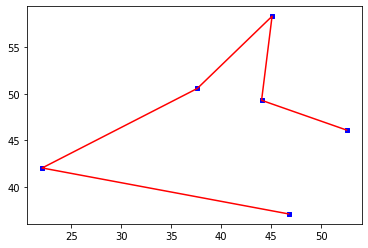

Vertices for locations are:
 [(46.7438178442938, 37.1248715385984), (22.0757382980061, 42.0458705004164), (37.6105020952811, 50.5648642532894), (45.0885991859118, 58.2955216096463), (44.0381681668617, 49.29169136708), (52.5421770712729, 46.1079951946237), (46.7438178442938, 37.1248715385984)]
Best path: [1, 2, 3, 5, 4, 6] 
Total distance: 71.7724330067812

Price for this route 4 is:  71.7724330067812


In [6]:
###########################################################################
##### Calculate the distance between 14 to 8 and negate from the path as van will not go back to store 14

g = Graph([         
(46.7438178442938,37.1248715385984),#14
(52.5421770712729,46.1079951946237),#8
])


###########################################################################
##### PART 11 = IMPORTANT ## Runs the main GA (including population size)

ga = GeneticAlgorithm(g, 100)    #Inputs (graph co-ordinates, POPULATION SIZE)  more = better, but takes longer
ga.run()


# ########## Output
best_tour = ga.best()
best_path = best_tour.vertices

dist_14_8 = best_tour._Tour__cost/2
print("Best path:", best_path, "\nDistance between 14 to 8:",dist_14_8)   #Prints the best path and distance



###########################################################################
##### PART 10 =  IMPORTANT ## Calculate the distance between these stores

g = Graph([    
(46.7438178442938,37.1248715385984),#14  
(22.0757382980061,42.0458705004164),#11 
(37.6105020952811,50.5648642532894),#3
(44.0381681668617,49.29169136708),#21
(45.0885991859118,58.2955216096463),#22
(52.5421770712729,46.1079951946237),#8
 
])

###########################################################################
##### PART 11 = IMPORTANT ## Runs the main GA (including population size)

ga = GeneticAlgorithm(g, 100)    #Inputs (graph co-ordinates, POPULATION SIZE)  more = better, but takes longer
ga.run()


########## Output
best_tour = ga.best()
g.plot2(best_tour)   #Plots the path on a graph

best_path = best_tour.vertices
size = len (g.vertices)
for i in range(size-1):
    best_path[i]=best_path[i]+1   #Must +1 to nodes to chnage numbering from (0,n-1) to (1,n)
best_path.insert(0,1)   #Adds start node to the list

# Negate the distance between store 14 to 8 as van will not go back to store 14
Dist_route4 = best_tour._Tour__cost - dist_14_8
print("Best path:", best_path, "\nTotal distance:",Dist_route4)   #Prints the best path and distance

######### Price 
# Van costs £1 per mile
P_Van1 = 1
Price_Rout4 = Dist_route4 * P_Van1
print("\nPrice for this route 4 is: ", Price_Rout4)

## Route 5 ------- 8 -> 13 -> 15 -> 18 -> 16 -> W1 (Return to warehouse 1)

Best path: [1] 
Distance between 8 to W1: 46.771018922963655


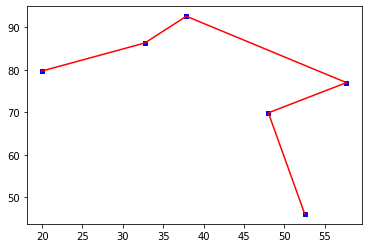

Vertices for locations are:
 [(52.5421770712729, 46.1079951946237), (48.039399290203, 69.8632165852765), (57.7102187574938, 76.9610339716859), (37.8697820230032, 92.5591094904637), (32.7323075124292, 86.2753678010589), (19.9906676704456, 79.6926263050003), (52.5421770712729, 46.1079951946237)]
Best path: [1, 2, 3, 4, 5, 6] 
Total distance: 83.87012547757553

Price for this route 5 is:  83.87012547757553


In [13]:
###########################################################################
##### PART 10 =  Calculate the distance between 8 to W1 and negate from the path as van will not go back to store 8

g = Graph([  
(19.9906676704456,79.6926263050003),#W1
(52.5421770712729,46.1079951946237),#8
])

###########################################################################
##### PART 11 = IMPORTANT ## Runs the main GA (including population size)

ga = GeneticAlgorithm(g, 100)    #Inputs (graph co-ordinates, POPULATION SIZE)  more = better, but takes longer
ga.run()


# ########## Output
best_tour = ga.best()
best_path = best_tour.vertices

dist_8_w1 = best_tour._Tour__cost/2
print("Best path:", best_path, "\nDistance between 8 to W1:",dist_8_w1)   #Prints the best path and distance



###########################################################################
##### PART 10 =  IMPORTANT ## Calculate the distance between these stores

#Practical 9, Question 5
g = Graph([    
(52.5421770712729,46.1079951946237),#8
(48.039399290203,69.8632165852765),#13
(57.7102187574938,76.9610339716859),#15
(37.8697820230032,92.5591094904637),#18  
(32.7323075124292,86.2753678010589),#16 
(19.9906676704456,79.6926263050003),#W1
  
])

###########################################################################
##### PART 11 = IMPORTANT ## Runs the main GA (including population size)

ga = GeneticAlgorithm(g, 100)    #Inputs (graph co-ordinates, POPULATION SIZE)  more = better, but takes longer
ga.run()


########## Output
best_tour = ga.best()
g.plot2(best_tour)   #Plots the path on a graph

best_path = best_tour.vertices
size = len (g.vertices)
for i in range(size-1):
    best_path[i]=best_path[i]+1   #Must +1 to nodes to chnage numbering from (0,n-1) to (1,n)
best_path.insert(0,1)   #Adds start node to the list

# Negate the distance between store W1 to 8 as van will not go back to store 8
Dist_route5 = best_tour._Tour__cost - dist_8_w1
print("Best path:", best_path, "\nTotal distance:", Dist_route5)   #Prints the best path and distance


######### Price 
# Van costs £1 per mile
P_Van1 = 1
Price_Rout5 = Dist_route5 * P_Van1
print("\nPrice for this route 5 is: ", Price_Rout5)

# Warehouse 2

## Route 6 ------- W2 -> 14 -> 8 -> W2     (Route for Lorry_2)

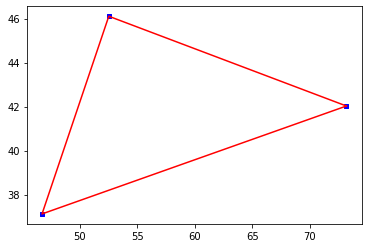

Vertices for locations are:
 [(73.1817470551995, 42.0285954296223), (46.7438178442938, 37.1248715385984), (52.5421770712729, 46.1079951946237), (73.1817470551995, 42.0285954296223)]
Best path: [1, 2, 3] 
Total distance: 58.61964526959218

Price for this route 6 is:  117.23929053918437


In [23]:
###########################################################################
##### PART 10 =  IMPORTANT ## Input the data for the problem

g = Graph([    
    
# Warehouse 2    
(73.1817470551995,42.0285954296223),#W2
(46.7438178442938,37.1248715385984),#14
(52.5421770712729,46.1079951946237),#8
    
])

###########################################################################
##### PART 11 = IMPORTANT ## Runs the main GA (including population size)

ga = GeneticAlgorithm(g, 100)    #Inputs (graph co-ordinates, POPULATION SIZE)  more = better, but takes longer
ga.run()


########## Output
best_tour = ga.best()
g.plot(best_tour)   #Plots the path on a graph

best_path = best_tour.vertices
size = len (g.vertices)
for i in range(size-1):
    best_path[i]=best_path[i]+1   #Must +1 to nodes to chnage numbering from (0,n-1) to (1,n)
best_path.insert(0,1)   #Adds start node to the list

Dist_route6 = best_tour._Tour__cost
print("Best path:", best_path, "\nTotal distance:",Dist_route6)   #Prints the best path and distance

######### Price 
#Lorry costs £2 per mile
P_Lorry = 2
Price_Rout6 = Dist_route6 * P_Lorry
print("\nPrice for this route 6 is: ", Price_Rout6)

## Route 7 -------- W2 -> 10 -> 19 -> 1 -> 7 W2

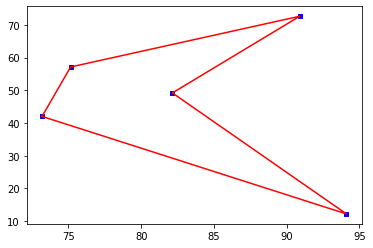

Vertices for locations are:
 [(73.1817470551995, 42.0285954296223), (94.1041534254341, 12.2284468976924), (82.141108510899, 49.206166784107), (90.8971962770689, 72.6439611285086), (75.1446122718255, 57.1376740230397), (73.1817470551995, 42.0285954296223)]
Best path: [1, 5, 4, 2, 3] 
Total distance: 137.63626702161088

Price for this route 7 is:  137.63626702161088


In [9]:
###########################################################################
##### PART 10 =  IMPORTANT ## Input the data for the problem

g = Graph([    
    
# Warehouse 2    
(73.1817470551995,42.0285954296223),#W2
(90.8971962770689,72.6439611285086),#1
(75.1446122718255,57.1376740230397),#19
(82.141108510899,49.206166784107),#10
(94.1041534254341,12.2284468976924),#7    
])

###########################################################################
##### PART 11 = IMPORTANT ## Runs the main GA (including population size)

ga = GeneticAlgorithm(g, 100)    #Inputs (graph co-ordinates, POPULATION SIZE)  more = better, but takes longer
ga.run()


########## Output
best_tour = ga.best()
g.plot(best_tour)   #Plots the path on a graph

best_path = best_tour.vertices
size = len (g.vertices)
for i in range(size-1):
    best_path[i]=best_path[i]+1   #Must +1 to nodes to chnage numbering from (0,n-1) to (1,n)
best_path.insert(0,1)   #Adds start node to the list
Dist_route7 = best_tour._Tour__cost
print("Best path:", best_path, "\nTotal distance:", Dist_route7)   #Prints the best path and distance

######### Price 
# Van costs £1 per mile
P_Van = 1
Price_Rout7 = Dist_route7 * P_Van
print("\nPrice for this route 7 is: ", Price_Rout7)

# Total Distance Travelled and Cost for it

In [10]:

print("Distance of route 1: ", Dist_route1)
print("Distance of route 2: ", Dist_route2)
print("Distance of route 3: ", Dist_route3)
print("Distance of route 4: ", Dist_route4)
print("Distance of route 5: ", Dist_route5)
print("Distance of route 6: ", Dist_route6)
print("Distance of route 7: ", Dist_route7)

Distance_Total = Dist_route1 + Dist_route2 + Dist_route3 + Dist_route4 + Dist_route5 + Dist_route6 + Dist_route7

print("\nTotal Distance covered to make all deliveries is:", Distance_Total)

print("\n---------------------------------------------------------")

print("Price of route 1: ", Price_Rout1)
print("Price of route 2: ", Price_Rout2)
print("Price of route 3: ", Price_Rout3)
print("Price of route 4: ", Price_Rout4)
print("Price of route 5: ", Price_Rout5)
print("Price of route 6: ", Price_Rout6)
print("Price of route 7: ", Price_Rout7)

Price_Total = Price_Rout1 + Price_Rout2 + Price_Rout3 + Price_Rout4 + Price_Rout5 + Price_Rout6 + Price_Rout7

print("\nTotal Cost to make all the deliveries is:", Price_Total)

Distance of route 1:  24.97452942286594
Distance of route 2:  55.512037557165414
Distance of route 3:  103.1847288582882
Distance of route 4:  71.7724330067812
Distance of route 5:  83.87012547757553
Distance of route 6:  58.61964526959218
Distance of route 7:  137.63626702161088

Total Distance covered to make all deliveries is: 535.5697666138794

---------------------------------------------------------
Price of route 1:  49.94905884573188
Price of route 2:  55.512037557165414
Price of route 3:  103.1847288582882
Price of route 4:  71.7724330067812
Price of route 5:  83.87012547757553
Price of route 6:  117.23929053918437
Price of route 7:  137.63626702161088

Total Cost to make all the deliveries is: 619.1639413063374
